In [1]:
pip install ciso8601

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import random
import copy
import tarfile
import pandas as pd
from datetime import datetime, timedelta
import ciso8601
import matplotlib.pyplot as plt
import random

In [3]:
df = pd.read_csv("C:/Users/user/Desktop/AML/thesis/data/CC_LCL-FullData.csv")

In [4]:
df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


In [5]:
# Renaming the power column and convert string to datetime and convert "Null" string to Nan
df.rename(columns={'KWH/hh (per half hour) ': 'load'},inplace=True)
df['DateTime'] = df['DateTime'].apply(lambda x:  ciso8601.parse_datetime(x[0:-8]))
df.load = pd.to_numeric(df.load,errors = 'coerce')

In [6]:
df.head()

,LCLid,stdorToU,DateTime,load
0,MAC000002,Std,2012-10-12 00:30:00,0.0
1,MAC000002,Std,2012-10-12 01:00:00,0.0
2,MAC000002,Std,2012-10-12 01:30:00,0.0
3,MAC000002,Std,2012-10-12 02:00:00,0.0
4,MAC000002,Std,2012-10-12 02:30:00,0.0


In [7]:
len(df['LCLid'].unique())

5566

In [8]:
# Keeping only standard tariff customers
df_std = df[df.stdorToU=='Std']

In [9]:
df_std.head()

,LCLid,stdorToU,DateTime,load
0,MAC000002,Std,2012-10-12 00:30:00,0.0
1,MAC000002,Std,2012-10-12 01:00:00,0.0
2,MAC000002,Std,2012-10-12 01:30:00,0.0
3,MAC000002,Std,2012-10-12 02:00:00,0.0
4,MAC000002,Std,2012-10-12 02:30:00,0.0


In [10]:
# finding which ids have data from the entirety of the 2013
start = datetime(year=2013, month = 1, day = 1, hour = 0, minute= 0, second= 0)
end = datetime(year=2013, month = 12, day = 31, hour = 23, minute= 30, second= 0)
ids = set(df_std[df_std['DateTime']==start].LCLid) & set(df_std[df_std['DateTime']==end].LCLid)

In [11]:
# Keeping data only for the year of 2013 and for the ids that have data for the entire 2013
df_std_2013 = df_std[(df_std.DateTime>=start)&(df_std.DateTime<=end)&(df_std.LCLid.isin(ids))]

In [12]:
# Dropping the necesarry duplicates and resetting index
df_std_2013.drop_duplicates(['LCLid','DateTime'],keep = 'first',inplace = True)
df_std_2013.reset_index(inplace=True, drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_8788\3250603378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_std_2013.drop_duplicates(['LCLid','DateTime'],keep = 'first',inplace = True)


In [13]:
df_std_2013.head()

,LCLid,stdorToU,DateTime,load
0,MAC000002,Std,2013-01-01 00:00:00,0.219
1,MAC000002,Std,2013-01-01 00:30:00,0.241
2,MAC000002,Std,2013-01-01 01:00:00,0.191
3,MAC000002,Std,2013-01-01 01:30:00,0.235
4,MAC000002,Std,2013-01-01 02:00:00,0.182


In [14]:
len(df_std_2013.LCLid.unique())

4039

In [15]:
# non zero load 
ids2 = set(df_std_2013.LCLid.unique()) - set(df_std_2013[(df_std_2013.load==0)]['LCLid'].unique())

In [16]:
len(ids2)

3282

In [17]:
df_std_2013 = df_std_2013[df_std_2013.LCLid.isin(ids2)]
df_std_2013.head()

,LCLid,stdorToU,DateTime,load
0,MAC000002,Std,2013-01-01 00:00:00,0.219
1,MAC000002,Std,2013-01-01 00:30:00,0.241
2,MAC000002,Std,2013-01-01 01:00:00,0.191
3,MAC000002,Std,2013-01-01 01:30:00,0.235
4,MAC000002,Std,2013-01-01 02:00:00,0.182


In [18]:
# finding those participants for which the difference between two consectuive rows' datetimes is more than an hour or less than half an hour
names = []
x = df_std_2013.groupby('LCLid')['DateTime'].diff()
y = x[(x > timedelta(hours=1))|(x < timedelta(minutes = 30))]

for idx in y.index:
    names.append(df_std_2013.loc[idx,'LCLid'])

In [19]:
df_std_2013_cleaned = df_std_2013[~df_std_2013.LCLid.isin(set(names))]
df_std_2013_cleaned.head(2)

,LCLid,stdorToU,DateTime,load
0,MAC000002,Std,2013-01-01 00:00:00,0.219
1,MAC000002,Std,2013-01-01 00:30:00,0.241


In [20]:
# Inserting rows at appropriate locations
# Calculate time difference between consecutive rows for each ID
df_std_2013_cleaned['time_diff'] = df_std_2013_cleaned.groupby('LCLid')['DateTime'].diff()


# Filter rows where time difference is greater than 30 minutes
rows_to_insert = df_std_2013_cleaned[df_std_2013_cleaned['time_diff'] > timedelta(minutes=30)].copy()

# Create new rows to be inserted
rows_to_insert['DateTime'] = rows_to_insert['DateTime'] - timedelta(minutes=30)

# Calculate the load as the average of previous and following rows
rows_to_insert['load'] = (rows_to_insert['load'].shift() + rows_to_insert['load'].shift(-1)) / 2

# Concatenate original DataFrame and rows to be inserted
df_std_2013_cleaned = pd.concat([df_std_2013_cleaned, rows_to_insert]).sort_values(['LCLid', 'DateTime']).reset_index(drop=True)



C:\Users\user\AppData\Local\Temp\ipykernel_8788\1131780227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_std_2013_cleaned['time_diff'] = df_std_2013_cleaned.groupby('LCLid')['DateTime'].diff()


In [ ]:
# Fill load Nans with average of the previous and latter. It was checked that for no id, the first or the last load value is Nan. Thus, no mixup between IDs
# Also dropping the time_diff column
df_std_2013_cleaned['load'] = df_std_2013_cleaned['load'].fillna((df_std_2013_cleaned['load'].ffill() + df_std_2013_cleaned['load'].bfill()) / 2)
df_std_2013_cleaned.drop('time_diff', axis=1,inplace = True)

In [22]:
# This shows that ony time diff is 30 mins
diff = df_std_2013_cleaned.groupby(['LCLid']).DateTime.diff()
set(diff[~(diff==timedelta(minutes = 30))])

{NaT}

In [80]:
# Create a new dataframe to store the aggregated rows
df_aggregated = pd.DataFrame()

# Assign the LCLid, stdorToU, and DateTime from the first row of every two rows
df_aggregated['LCLid'] = df_ids['LCLid'].iloc[::2].values
df_aggregated['stdorToU'] = df_ids['stdorToU'].iloc[::2].values
df_aggregated['DateTime'] = df_ids['DateTime'].iloc[::2].values

# Combine the Load values of every two consecutive rows
df_aggregated['load'] = df_ids['load'].iloc[::2].values + df_ids['load'].iloc[1::2].values

#Assign the Acorn from the first row of every two rows
df_aggregated['Acorn'] = df_ids['Acorn'].iloc[::2].values

df_aggregated.sort_values(['LCLid', 'DateTime'], ascending=[True, True]).reset_index(drop = True)

,LCLid,stdorToU,DateTime,load,Acorn
0,MAC000002,Std,2013-01-01 00:00:00,0.460,ACORN-A
1,MAC000002,Std,2013-01-01 01:00:00,0.426,ACORN-A
2,MAC000002,Std,2013-01-01 02:00:00,0.411,ACORN-A
3,MAC000002,Std,2013-01-01 03:00:00,0.395,ACORN-A
4,MAC000002,Std,2013-01-01 04:00:00,0.221,ACORN-A
...,...,...,...,...,...
22241635,MAC005567,Std,2013-12-31 19:00:00,0.227,ACORN-Q
22241636,MAC005567,Std,2013-12-31 20:00:00,0.112,ACORN-Q
22241637,MAC005567,Std,2013-12-31 21:00:00,0.104,ACORN-Q
22241638,MAC005567,Std,2013-12-31 22:00:00,0.101,ACORN-Q


In [81]:
df_aggregated.groupby(['LCLid','Acorn']).count().groupby(['Acorn']).count()

,stdorToU,DateTime,load
Acorn,,,
ACORN-A,73,73,73
ACORN-B,14,14,14
ACORN-C,73,73,73
ACORN-D,130,130,130
ACORN-E,643,643,643
ACORN-F,305,305,305
ACORN-G,106,106,106
ACORN-H,260,260,260
ACORN-I,30,30,30


In [82]:
df_aggregated.head()

,LCLid,stdorToU,DateTime,load,Acorn
0,MAC000002,Std,2013-01-01 00:00:00,0.460,ACORN-A
1,MAC000002,Std,2013-01-01 01:00:00,0.426,ACORN-A
2,MAC000002,Std,2013-01-01 02:00:00,0.411,ACORN-A
3,MAC000002,Std,2013-01-01 03:00:00,0.395,ACORN-A
4,MAC000002,Std,2013-01-01 04:00:00,0.221,ACORN-A


In [83]:
# This shows that ony time diff is 1 hour
diff = df_aggregated.groupby(['LCLid']).DateTime.diff()
set(diff)

{NaT, Timedelta('0 days 01:00:00')}

In [84]:
from datetime import datetime

# adding the day of the week and hour column
df_aggregated['Weekday'] = df_aggregated.DateTime.apply(lambda x: x.weekday())
df_aggregated['Hour'] = df_aggregated.DateTime.apply(lambda x: int(x.strftime("%H")))

In [85]:
df_aggregated.head(1)

,LCLid,stdorToU,DateTime,load,Acorn,Weekday,Hour
0,MAC000002,Std,2013-01-01,0.46,ACORN-A,1,0


In [86]:
# K-means clustering
df_k_means = df_aggregated[['LCLid','load']].groupby(['LCLid']).agg(['mean','median','sum','max','min'])

grouped_df = df_aggregated.groupby(['LCLid', 'Weekday'])['load'].mean().reset_index()
min_load_indexes = grouped_df.groupby('LCLid')['load'].idxmin()
max_load_indexes = grouped_df.groupby('LCLid')['load'].idxmax()

min_load_df = grouped_df.loc[min_load_indexes]
max_load_df = grouped_df.loc[max_load_indexes]

min_load_df = min_load_df.rename(columns={'Weekday': 'Weekday_min'})
max_load_df = max_load_df.rename(columns={'Weekday': 'Weekday_max'})

result_df = pd.merge(min_load_df[['LCLid', 'Weekday_min']],
                     max_load_df[['LCLid', 'Weekday_max']],
                     on='LCLid')

df_k_means = pd.merge(df_k_means, result_df, on='LCLid')


import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming 'df_k_means' is your dataframe with columns 'LCLid' and other relevant columns for clustering.

clustering_data = df_k_means.drop('LCLid', axis=1)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(clustering_data)

k = 18
kmeans = KMeans(n_clusters=k, random_state=0)
df_k_means['Cluster'] = kmeans.fit_predict(standardized_data)

df_k_means.head(2)

C:\Users\user\AppData\Local\Temp\ipykernel_15508\345354599.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df_k_means = pd.merge(df_k_means, result_df, on='LCLid')
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


,LCLid,"(load, mean)","(load, median)","(load, sum)","(load, max)","(load, min)",Weekday_min,Weekday_max,Cluster
0,MAC000002,0.481124,0.324,4214.648000,4.586,0.170,0,6,17
1,MAC000003,0.800296,0.371,7010.590503,7.241,0.014,5,0,6


In [87]:
df_k_means.groupby(['Cluster'])['LCLid'].count()

Cluster
0     146
1      39
2     165
3     162
4     298
5      11
6      76
7      57
8      34
9     168
10    254
11    183
12    232
13      1
14     80
15    307
16    217
17    109
Name: LCLid, dtype: int64

(array([ 2.,  9., 20., 44., 52., 39., 53., 45., 29.,  5.]),
 array([0.03802289, 0.07263682, 0.10725075, 0.14186469, 0.17647862,
        0.21109255, 0.24570648, 0.28032042, 0.31493435, 0.34954828,
        0.38416221]),
 <BarContainer object of 10 artists>)

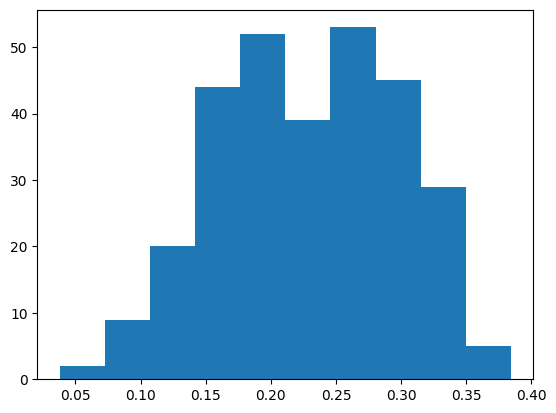

In [88]:
#histogram for mean energy from cluster 4 (cluster with max houses)
plt.hist(df_k_means[df_k_means.Cluster==4][('load'),('mean')])

In [89]:
df_weather = pd.read_csv('weather_hourly_darksky.csv')
df_weather.rename(columns={'time': 'DateTime'},inplace=True)
df_weather['DateTime'] = df_weather['DateTime'].apply(lambda x:  ciso8601.parse_datetime(x))
df_weather.sort_values(['DateTime'],inplace = True)
df_weather.reset_index(drop = True,inplace = True)
df_weather.head(2)

idx = df_weather[df_weather['DateTime'].diff()==timedelta(hours = 3)].index[0]

In [90]:
df_weather = pd.read_csv('weather_hourly_darksky.csv')
df_weather.rename(columns={'time': 'DateTime'},inplace=True)
df_weather['DateTime'] = df_weather['DateTime'].apply(lambda x:  ciso8601.parse_datetime(x))
df_weather.sort_values(['DateTime'],inplace = True)
df_weather.reset_index(drop = True,inplace = True)
df_weather.head(2)

idx = df_weather[df_weather['DateTime'].diff()==timedelta(hours = 3)].index[0]
print(idx)


#inserting missing rows. only one pair of consecutive rows for which diff is more than 1 (3hrs). same apparent temp
# Create the new DataFrame with new rows
row1 = copy.deepcopy(df_weather.iloc[idx-1])
row1['DateTime'] = row1['DateTime'] + timedelta(hours = 1)
row2 = copy.deepcopy(df_weather.iloc[idx-1])
row2['DateTime'] = row2['DateTime'] + timedelta(hours = 2)

# Concatenate the new rows with the original DataFrame and sort the index
df_weather = pd.concat([df_weather.iloc[:idx], pd.DataFrame([row1]),pd.DataFrame([row2]), df_weather.iloc[idx:]]).reset_index(drop=True)
df_weather.sort_values(['DateTime'],inplace = True)
df_weather.reset_index(drop = True,inplace = True)


16295


In [91]:
df_aggregated

,LCLid,stdorToU,DateTime,load,Acorn,Weekday,Hour
0,MAC000002,Std,2013-01-01 00:00:00,0.460,ACORN-A,1,0
1,MAC000002,Std,2013-01-01 01:00:00,0.426,ACORN-A,1,1
2,MAC000002,Std,2013-01-01 02:00:00,0.411,ACORN-A,1,2
3,MAC000002,Std,2013-01-01 03:00:00,0.395,ACORN-A,1,3
4,MAC000002,Std,2013-01-01 04:00:00,0.221,ACORN-A,1,4
...,...,...,...,...,...,...,...
22241635,MAC005567,Std,2013-12-31 19:00:00,0.227,ACORN-Q,1,19
22241636,MAC005567,Std,2013-12-31 20:00:00,0.112,ACORN-Q,1,20
22241637,MAC005567,Std,2013-12-31 21:00:00,0.104,ACORN-Q,1,21
22241638,MAC005567,Std,2013-12-31 22:00:00,0.101,ACORN-Q,1,22


In [93]:
# decide here whether to choose Acorn-E or cluster 4
# ids = df_k_means[df_k_means.Cluster == 4].LCLid.unique()
# df_aggregated = df_aggregated[df_aggregated.LCLid.isin(ids)].sort_values(['LCLid','DateTime']).reset_index(drop = True)

df_aggregated = df_aggregated[df_aggregated.Acorn=="ACORN-E"].sort_values(['LCLid','DateTime']).reset_index(drop = True)

In [94]:
# Adding apparent temperature
df_aggregated = pd.merge(df_aggregated, df_weather[['DateTime','apparentTemperature']], on='DateTime', how='left')
df_aggregated.head(1)


,LCLid,stdorToU,DateTime,load,Acorn,Weekday,Hour,apparentTemperature
0,MAC000018,Std,2013-01-01,0.378,ACORN-E,1,0,3.66


In [95]:
# Step 3: Group the dataframe by LCLid and weekday/weekend category
grouped = df_aggregated.groupby(['LCLid', df_aggregated['DateTime'].dt.weekday.isin([5, 6])])

# Step 4: Create a new column with default values for AVG4D
df_aggregated['AVG4D'] = pd.Series(dtype='float64')

# Step 5: Define a function to calculate AVG4D using rolling window
def calculate_avg4d(group):
    # Identify current day's category
    is_weekend = group.name[1]

    # Calculate rolling average load over a window of 4 days
    rolling_avg = group['load'].rolling(window=4, min_periods=1).mean()
    
    # Assign rolling average values to AVG4D column
    group['AVG4D'] = rolling_avg
    
    return group

# Step 6: Apply the function to each group
grouped.apply(calculate_avg4d)

C:\Users\user\AppData\Local\Temp\ipykernel_15508\4092574308.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped.apply(calculate_avg4d)


,LCLid,stdorToU,DateTime,load,Acorn,Weekday,Hour,apparentTemperature,AVG4D
0,MAC000018,Std,2013-01-01 00:00:00,0.378,ACORN-E,1,0,3.66,0.37800
1,MAC000018,Std,2013-01-01 01:00:00,0.277,ACORN-E,1,1,4.24,0.32750
2,MAC000018,Std,2013-01-01 02:00:00,0.257,ACORN-E,1,2,3.74,0.30400
3,MAC000018,Std,2013-01-01 03:00:00,0.257,ACORN-E,1,3,3.89,0.29225
4,MAC000018,Std,2013-01-01 04:00:00,0.414,ACORN-E,1,4,3.34,0.30125
...,...,...,...,...,...,...,...,...,...
5632675,MAC005566,Std,2013-12-31 19:00:00,0.220,ACORN-E,1,19,3.46,0.21325
5632676,MAC005566,Std,2013-12-31 20:00:00,0.221,ACORN-E,1,20,2.92,0.21375
5632677,MAC005566,Std,2013-12-31 21:00:00,0.220,ACORN-E,1,21,2.79,0.21750
5632678,MAC005566,Std,2013-12-31 22:00:00,0.170,ACORN-E,1,22,3.32,0.20775


In [96]:
df_weather.head(1)

,visibility,windBearing,temperature,DateTime,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,13.63,160,13.49,2011-11-01,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear


In [97]:
import numpy as np
import pandas as pd

# Sort the dataframe by DateTime in ascending order
df_aggregated = df_aggregated.sort_values('DateTime')

# Create a boolean mask to identify weekdays and weekends
is_weekday = ~(df_aggregated['DateTime'].dt.dayofweek.isin([5,6]))

# Create rolling windows for weekdays and weekends, considering the same time and LCLid
weekday_window = df_aggregated[is_weekday].groupby(['LCLid', df_aggregated['DateTime'].dt.time])['load'].rolling(4,min_periods = 1)
weekend_window = df_aggregated[~is_weekday].groupby(['LCLid', df_aggregated['DateTime'].dt.time])['load'].rolling(4,min_periods = 1)

# Compute the average load for each rolling window
df_aggregated['AVG4D'] = np.nan
df_aggregated.loc[is_weekday, 'AVG4D'] = weekday_window.mean().reset_index(level=[0, 1], drop=True)
df_aggregated.loc[~is_weekday, 'AVG4D'] = weekend_window.mean().reset_index(level=[0, 1], drop=True)

df_aggregated.sort_values(['LCLid', 'DateTime', 'Acorn'], ascending=[True, True, True],inplace = True)
df_aggregated.reset_index(drop = True,inplace = True)


In [98]:
len(df_aggregated['LCLid'].unique())

643

In [99]:
# tempcluster
import numpy as np
from sklearn.cluster import KMeans

# Create a sample series
series = df_aggregated['apparentTemperature']

# Reshape the series to a 2D array
X = series.values.reshape(-1, 1)

# Apply K-means clustering with K = 2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Get the cluster labels for each point
labels = kmeans.labels_

# Print the cluster labels
print(labels)


[0 0 0 ... 0 0 0]


In [100]:
df_aggregated['TempCluster'] = labels

In [101]:
# df_cluster_4 = df_aggregated
df_acorn_e = df_aggregated

In [102]:
import pickle
# with open('df_cluster_4.pkl', 'wb') as f:
#     pickle.dump(df_cluster_4, f)  # Save DataFrame to a pickle file

with open('df_acorn_e.pkl', 'wb') as f:
    pickle.dump(df_acorn_e, f)  # Save DataFrame to a pickle file